In [1]:
from train import *
from constants import *

2023-05-03 14:49:52.237794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
config = 'config_mf_replicate_testnoiseT.yaml'
with open(config) as config_file:
    config = yaml.load(config_file, yaml.loader.SafeLoader)

Config.set_sub_day(config["sub_day"])

combined_ds = get_combined_ds(config)
train_df, test_df = create_train_test_df(combined_ds, config["test_noise"])

self = TransformerModel(scaler=config['scaler'])


In [5]:
x, y = next(iter(train_df.shuffle(100_000).batch(
    1024).prefetch(tf.data.AUTOTUNE)))


2023-04-26 14:41:31.272838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 42076 of 100000
2023-04-26 14:41:35.026143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [6]:
ts, history, target_ts, task = x['ts'], x['history'], x['target_ts'], x['task']

# Build position encodings
year = self.tc(ts, YEAR)
delta_year = tf.clip_by_value(
    year[:, -1:] - year, 0, self.pos_year.periods)
pos_embedding = self.concat_pos([
    self.pos_year(delta_year),
    self.pos_month(self.tc(ts, MONTH)),
    self.pos_day(self.tc(ts, DAY)),
    self.pos_dow(self.tc(ts, DOW)),
])
mask = year > 0

# Embed history
history_channels = tf.expand_dims(history, axis=-1)
#         scale = self.max_scaling(history_channels) + self.epsilon
#         scaled = history_channels / scale
scale, scaled = self.robust_scaler(history_channels, self.epsilon)


In [13]:
x.numpy()

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.2784951 ],
       [1.2490934 ],
       [1.2190119 ],
       [1.0973755 ],
       [1.0143738 ],
       [1.0662056 ],
       [0.9621903 ],
       [0.97290516],
       [0.94855124],
       [0.9421574 ],
       [0.968

In [11]:
from scipy import fft
fft.fft(x,)

AttributeError: 'DType' object has no attribute 'kind'

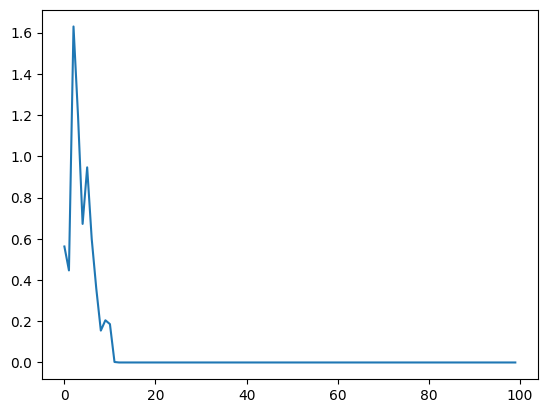

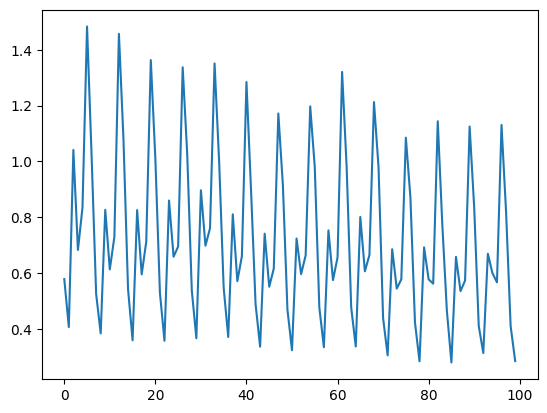

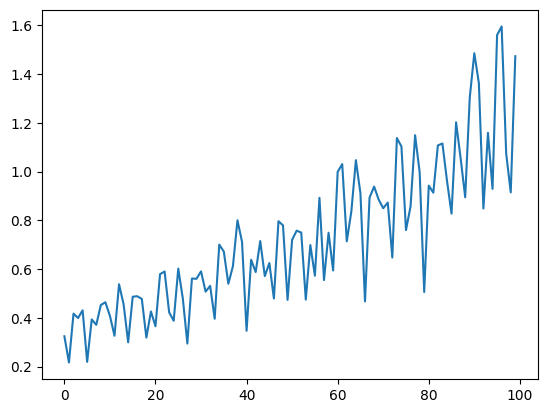

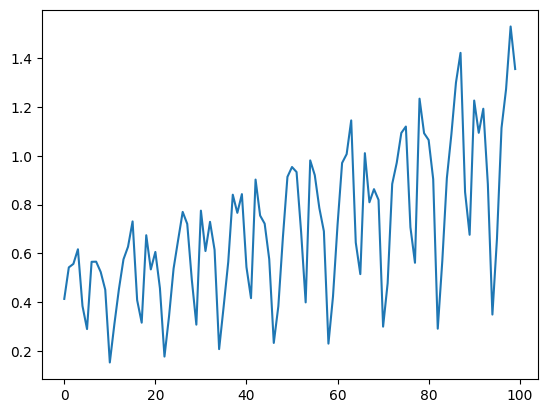

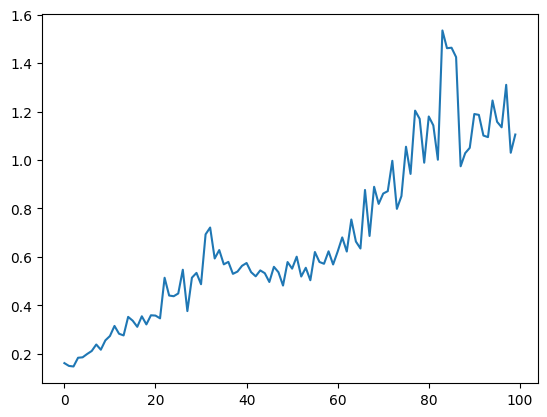

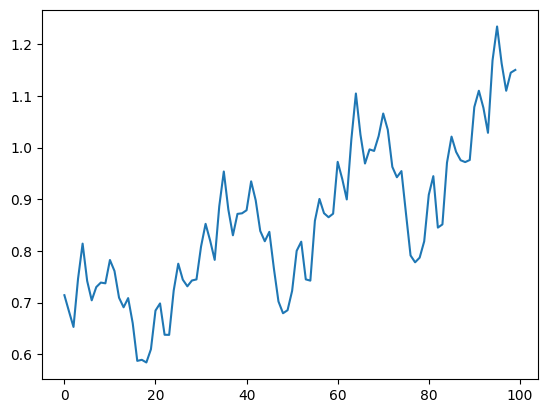

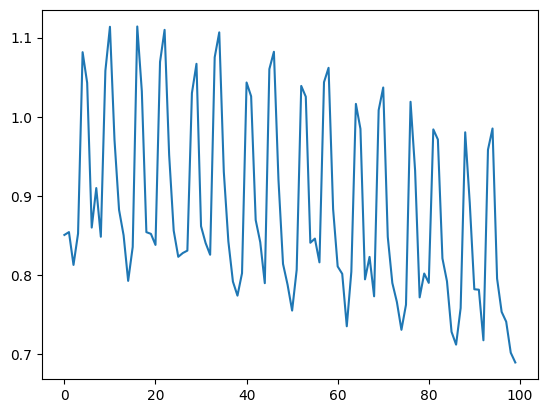

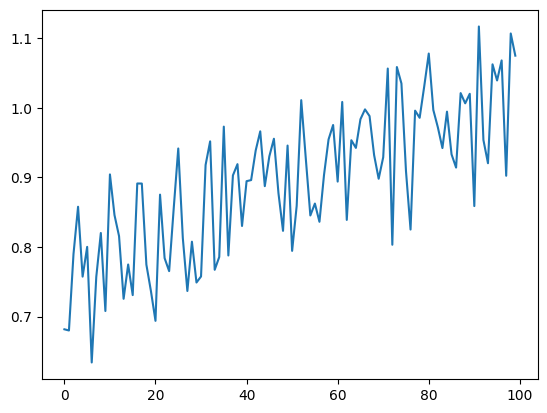

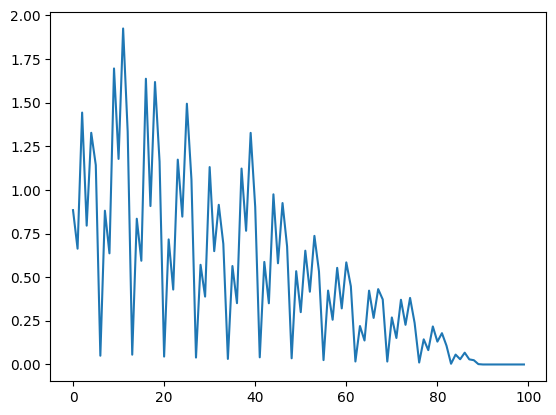

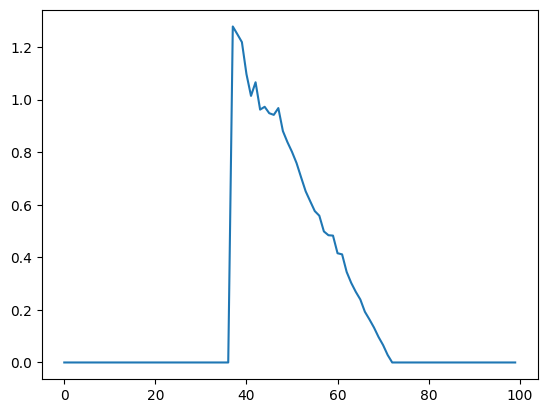

In [9]:
import matplotlib.pyplot as plt
for x in scaled[:10]:
    plt.plot(x)
    plt.show()


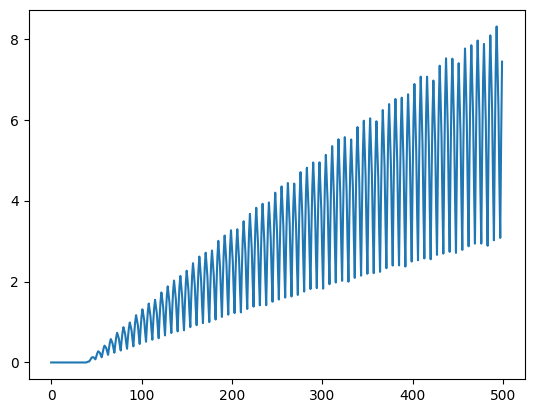

In [31]:
# Visualization of synthetic data
%matplotlib inline

plot_with_noise = False # toggle this to plot the data with noise added
num_plots = 1 # number of series you wish to see
PLOT_LEN = 200

data_list = list(datasets[0].take(num_plots))

for data in data_list:
    values = data['y'].numpy()
    noise = data['noise'].numpy()
    dates = [pd.to_datetime(ts) for ts in data['ts']]
    dates = list(range(len(dates)))

    if plot_with_noise:
        noisy_values = noise * values
        noisy_values = tf.expand_dims(tf.expand_dims(noisy_values[:PLOT_LEN], axis=0), axis=-1)
        scale, scaled_values = robust_scaler(noisy_values, 0)

        noisy_values, scaled_values = tf.squeeze(noisy_values), tf.squeeze(noisy_values)
        plt.plot(dates, scaled_values)
        plt.show()
    else:
        plt.plot(dates, values)
        plt.show()

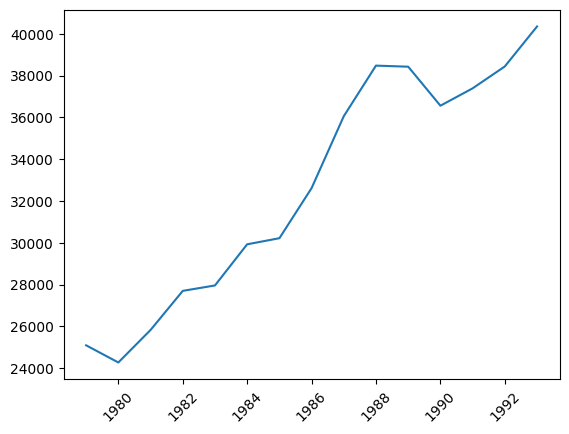

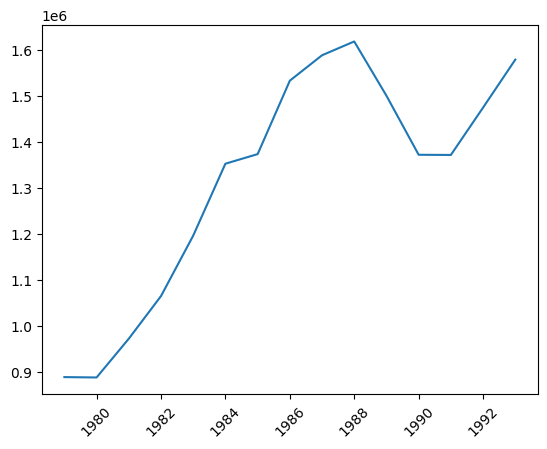

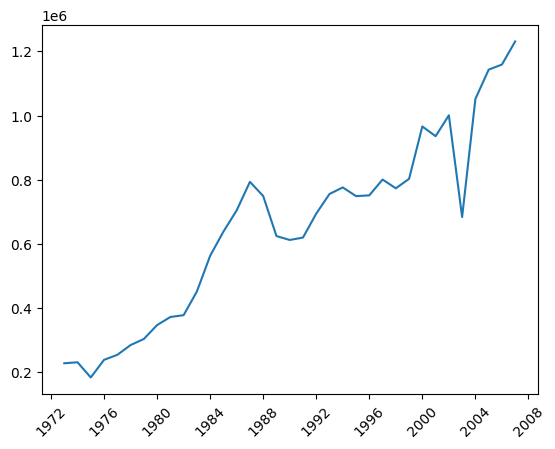

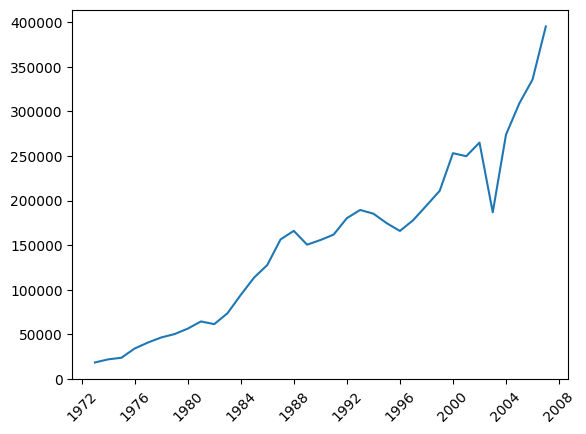

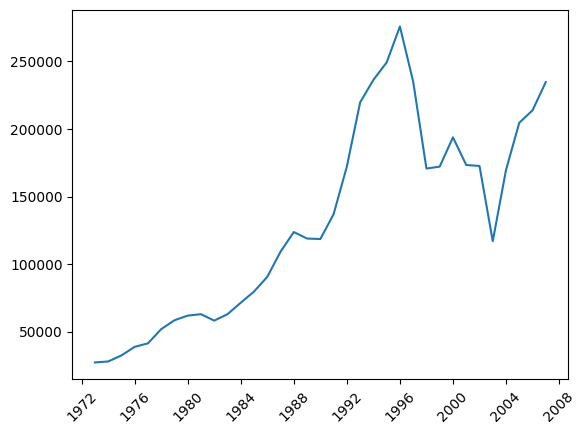

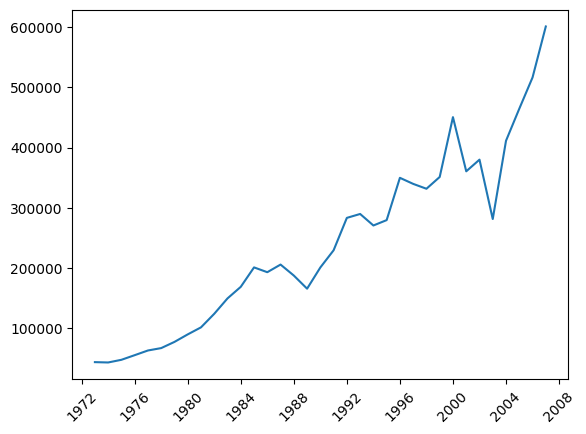

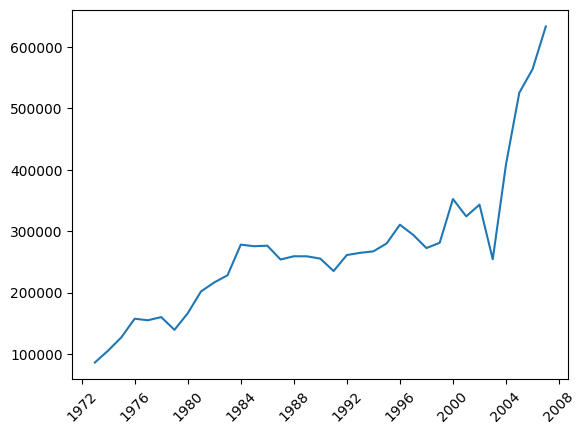

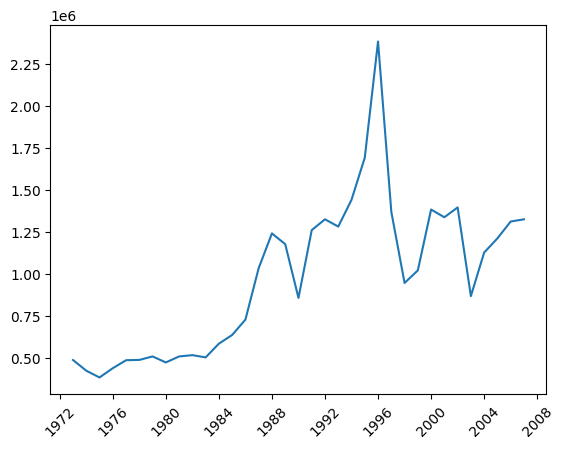

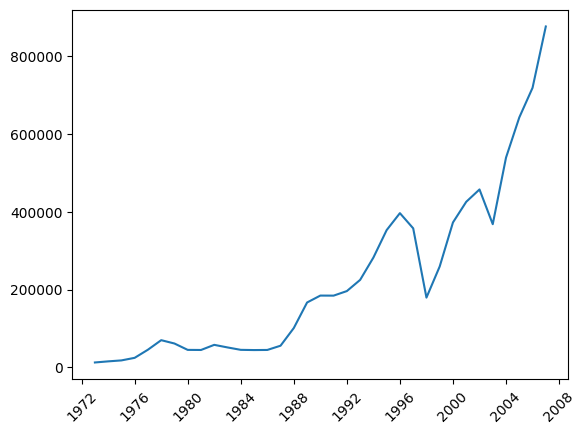

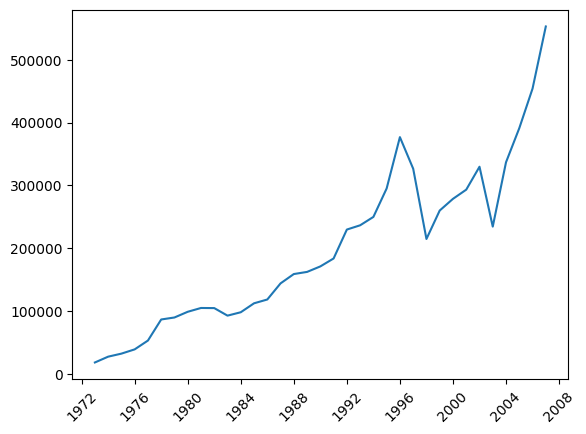

In [16]:
# Visualization of Tourism Data
%matplotlib inline

num_plots = 10 # number of series you wish to see

target_input, target_output = TourismDataset(
        TourismMeta.dataset_path).standard_split()

true = pd.DataFrame(target_output.values())

ts_input = target_input.time_stamps()
ts_output = target_output.time_stamps()

for i in range(num_plots):
    x = target_input.values()[i]
    y = target_output.values()[i]
    plt.plot(np.append(ts_input[i], ts_output[i]), np.append(x,y))
    plt.xticks(rotation=45)
    plt.show()

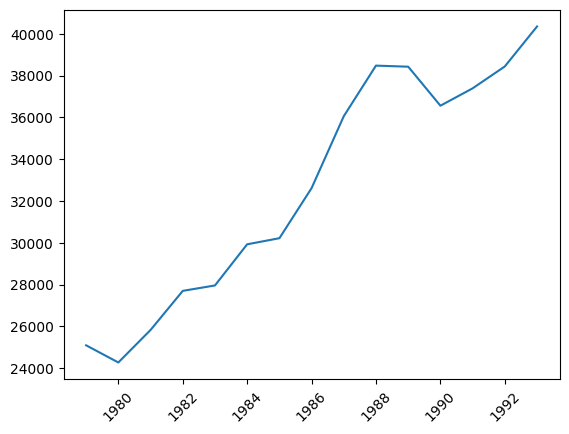

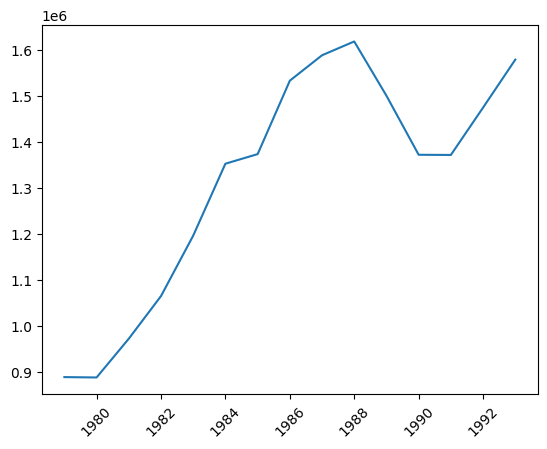

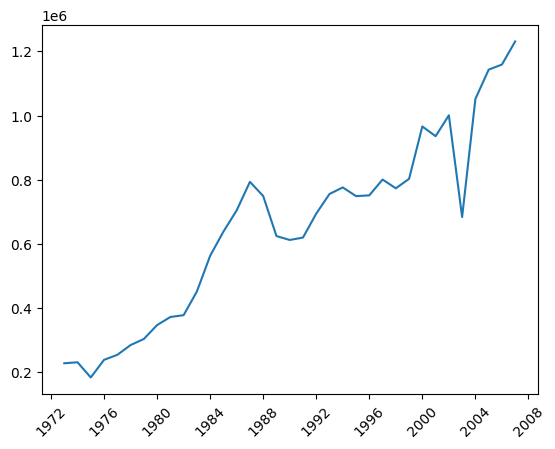

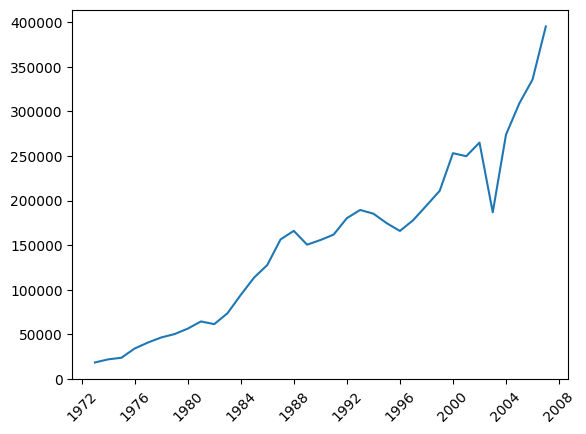

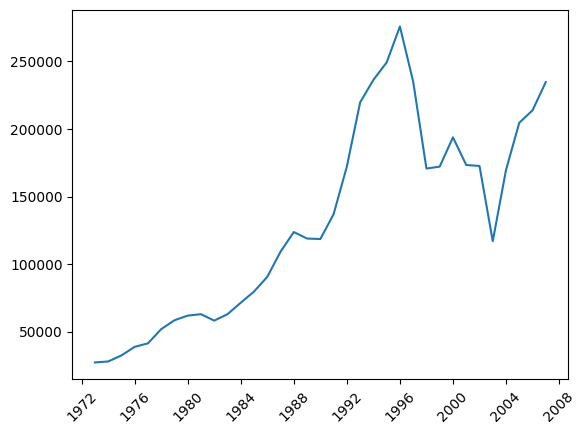

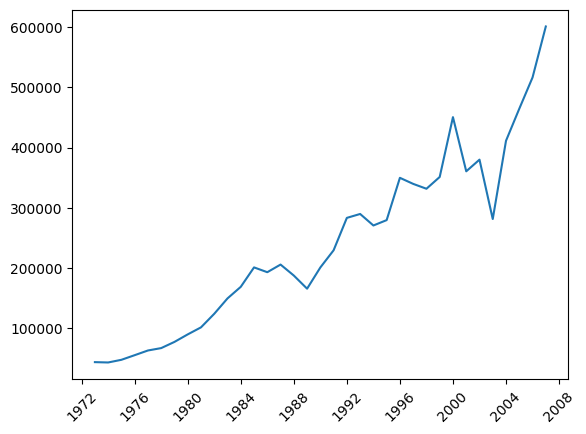

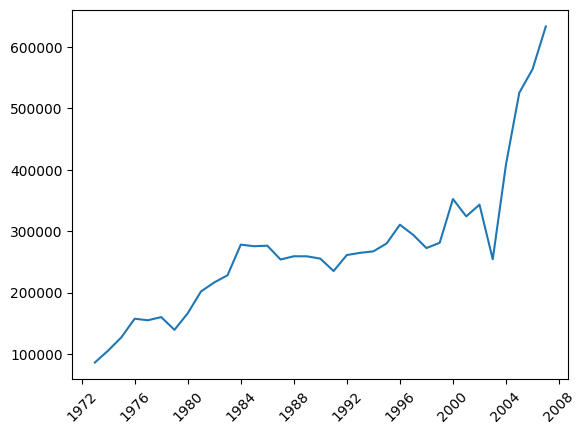

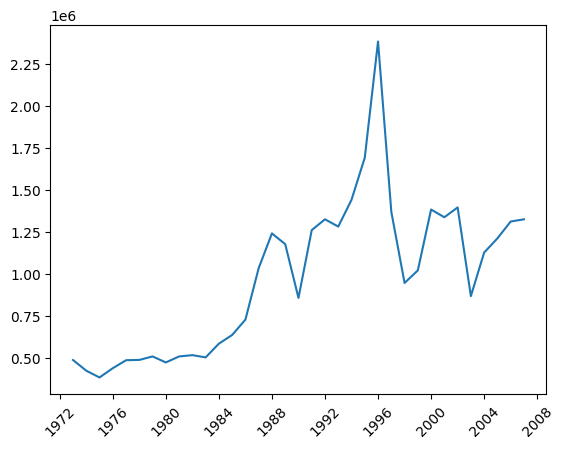

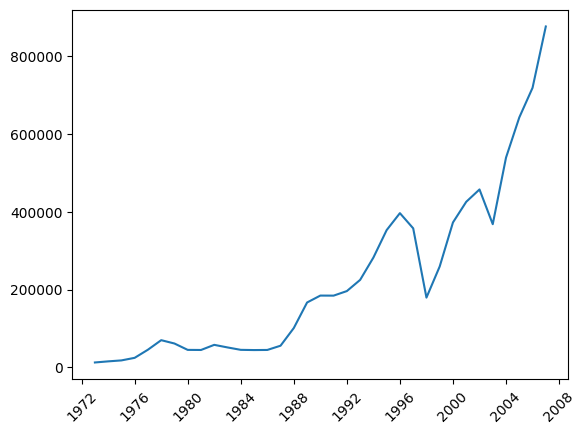

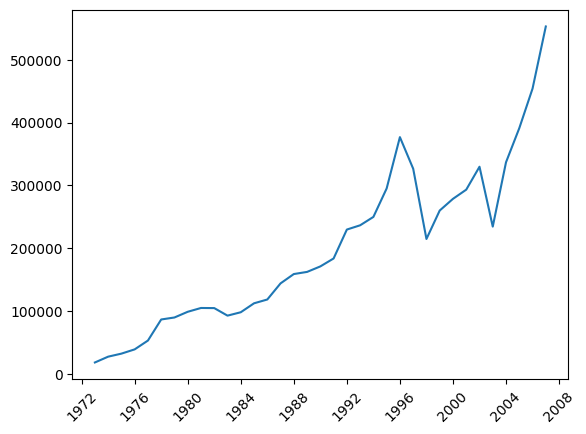

In [17]:
# Visualization of M3 dataset
target_input, target_output = M3Dataset(
        M3Meta.dataset_path).standard_split()

num_plots = 10 # number of series you wish to see

target_input, target_output = TourismDataset(
        TourismMeta.dataset_path).standard_split()

true = pd.DataFrame(target_output.values())

ts_input = target_input.time_stamps()
ts_output = target_output.time_stamps()

for i in range(num_plots):
    x = target_input.values()[i]
    y = target_output.values()[i]
    plt.plot(np.append(ts_input[i], ts_output[i]), np.append(x,y))
    plt.xticks(rotation=45)
    plt.show()